# Anticipate building consumption needs

## <i>Exploration and data cleaning (part 1)</i>

My mission here for the city of Seattle is to attempt to predict the CO2 emissions and total energy consumption of non-residential buildings for which they have not been measured.

The structural data of the buildings used to fulfill this mission were recorded in 2016 by the city (here their [source](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)).

In this first part we will clean our data set, carry out a short exploratory analysis and standardize our data so that it can be used to train different prediction models we will choose in the second and third parts to best meet the demand.<br><br>

<u><strong>Summary</strong></u> :<br>
<br>
<strong>Tools </strong> [(here)](#another_cell_0)<br>
 
<strong>I. Feature engineering and exploratory analysis</strong><br>
     -- A. 2016_Building_Energy_Benchmarking.xlsx: dataset description and cleaning<br>
     ---- <i>☛ Data set loading and description [(here)](#another_cell_a)<br>
     ---- ☛ Check null and duplicates values on primarey key [(here)](#another_cell_b)<br>
     ---- ☛ Filter our dataframe on non residential buildings [(here)](#another_cell_c)<br>
     ---- ☛ Variables description and selection [(here)](#another_cell_d)<br>
     ---- ☛ Encoding qualitative data [(here)](#another_cell_e)<br></i>
     -- B. 2016_Building_Energy_Benchmarking.xlsx: exploratory analysis<br>
     ---- <i>☛ Correlation between the total surface of a building and its CO2 emissions (intensity) [(here)](#another_cell_f)<br>
     ---- ☛ Correlation between the total surface of a building and its energy consumption (intensity) [(here)](#another_cell_g)<br>
     ---- ☛ Correlation between the year of construction of a building and its CO2 emissions [(here)](#another_cell_h)<br>
     ---- ☛ Correlation between the year of construction of a building and its energy consumption [(here)](#another_cell_i)<br></i>
     -- C. 2016_Building_Energy_Benchmarking.xlsx: data standardization<br>
     ---- <i>☛ Quantitative data standardisation [(here)](#another_cell_j)<br>
     ---- ☛ Scaling the YearBuild variable [(here)](#another_cell_k)<br></i>

<strong>Conclusion (part 1) </strong> [(here)](#another_cell_l)

<a id='another_cell_0'></a>

### Tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Check null values function :
def check_nan(data, column):
    if len(data[data[column].isnull()]) == 0:
        print ("The column", column, "does not contain any missing values")
    else :
        print("The column", column, "contain ", len(data[data[column].isnull()]), " missing values")
        
# Check duplicates function :
def check_duplicates(data, column):
    n = len(data.index)
    if len(data[column].drop_duplicates()) == n :
        print ("The column", column, "does not contain duplicates")
    else :
        print("The column", column, "contains ", len(data[data[column].duplicated()]), " duplicates.")
        return data[data[column].duplicated()]

In [3]:
def one_hot_encode_categorical_variables(data, columns):
    # Select the categorical columns
    categorical_data = data[columns]

    # Create an instance of OneHotEncoder
    encoder = OneHotEncoder(sparse=False)

    # Fit and transform the data
    encoded_data = encoder.fit_transform(categorical_data)

    # Create column names for the encoded variables
    encoded_column_names = encoder.get_feature_names(columns)

    # Create a DataFrame for the encoded variables
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)

    # Reset index for both dataframes
    data.reset_index(drop=True, inplace=True)
    encoded_df.reset_index(drop=True, inplace=True)

    # Concatenate the original DataFrame with the encoded DataFrame
    data = pd.concat([data, encoded_df], axis=1)
    
    # Drop the original categorical columns
    data = data.drop(columns=columns)

    return data

## I. Feature engineering and exploratory analysis

### A. <i>2016_Building_Energy_Benchmarking.xlsx</i> : dataset description and cleaning

<a id='another_cell_a'></a>

- <strong>Data set loading and description</strong>

In [4]:
data = pd.read_excel(r"C:\Users\hp\Desktop\Formations\Formation OpenClassroom\Projets DS V2\P4 - Anticipate building consumption needs/2016_Building_Energy_Benchmarking.xlsx")

In [5]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [6]:
data.shape

(3376, 46)

In [7]:
# Columns labels
print("Columns labels :", data.columns.tolist())

Columns labels : ['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


<a id='another_cell_b'></a>

- <strong>Check null and duplicates values on primarey key</strong>

In [8]:
check_nan(data, "OSEBuildingID")

The column OSEBuildingID does not contain any missing values


In [9]:
check_duplicates(data, "OSEBuildingID")

The column OSEBuildingID does not contain duplicates


<div class="alert-success">
    <u>Notice</u> :
<i><li> The "OSEBuildingID" column represent the buildings' ids
<li> It seems to be the primarey key here
<li> We count 3376 buildings' ids and 46 variables in this dataframe
</li></i></div>

<a id='another_cell_c'></a>

- <strong>Filter our dataframe on non residential buildings</strong>

In [10]:
# Building types list
data["BuildingType"].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [11]:
# Get names of indexes for rows to drop
indexNames = data[(data["BuildingType"] == "Multifamily MR (5-9)") | 
                  (data["BuildingType"] == "Multifamily LR (1-4)") | 
                  (data["BuildingType"] == "Multifamily HR (10+)")].index
# Delete these row indexes from original dataFrame
data.drop(indexNames, inplace=True)
print(f"Our dataframe contains {len(data.index)} unique buildings now.")

Our dataframe contains 1668 unique buildings now.


<a id='another_cell_d'></a>

- <strong>Variables description and selection</strong>

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1668 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1668 non-null   int64  
 1   DataYear                         1668 non-null   int64  
 2   BuildingType                     1668 non-null   object 
 3   PrimaryPropertyType              1668 non-null   object 
 4   PropertyName                     1668 non-null   object 
 5   Address                          1668 non-null   object 
 6   City                             1668 non-null   object 
 7   State                            1668 non-null   object 
 8   ZipCode                          1652 non-null   float64
 9   TaxParcelIdentificationNumber    1668 non-null   object 
 10  CouncilDistrictCode              1668 non-null   int64  
 11  Neighborhood                     1668 non-null   object 
 12  Latitude            

In [13]:
print("The variable Comments has no value at all")
print(f"The variable City has only one unique value : {data.City.unique()}")
print(f"The variable DataYear has only one unique value : {data.DataYear.unique()}")
print(f"The variable State has only one unique value : {data.State.unique()}")

The variable Comments has no value at all
The variable City has only one unique value : ['Seattle']
The variable DataYear has only one unique value : [2016]
The variable State has only one unique value : ['WA']


<div class="alert-danger">
☛ We can delete those columns :
</div>

In [14]:
del data["Comments"]
del data["City"]
del data["DataYear"]
del data["State"]
data.shape

(1668, 42)

<div class="alert-success">
☛ Our dataframe contains 1668 unique buildings and 42 variables now
</div>

In [15]:
data.to_csv("export_building_energy_bench_data_all.csv", sep=';')

# Display each qualitative variables unique values
for column in data.columns:
    if data[column].dtype == 'object':
        print(f"{column} unique value(s):", "\n")
        print(f"{data[column].unique()}", "\n")

BuildingType unique value(s): 

['NonResidential' 'Nonresidential COS' 'SPS-District K-12' 'Campus'
 'Nonresidential WA'] 

PrimaryPropertyType unique value(s): 

['Hotel' 'Other' 'Mixed Use Property' 'K-12 School' 'University'
 'Small- and Mid-Sized Office' 'Self-Storage Facility' 'Warehouse'
 'Large Office' 'Senior Care Community' 'Medical Office' 'Retail Store'
 'Hospital' 'Residence Hall' 'Distribution Center' 'Worship Facility'
 'Supermarket / Grocery Store' 'Laboratory' 'Refrigerated Warehouse'
 'Restaurant' 'Low-Rise Multifamily' 'Office'] 

PropertyName unique value(s): 

['Mayflower park hotel' 'Paramount Hotel' '5673-The Westin Seattle' ...
 'Queen Anne Pool' 'South Park Community Center'
 'Van Asselt Community Center'] 

Address unique value(s): 

['405 Olive way' '724 Pine street' '1900 5th Avenue' ... '1920 1st Ave W'
 '8319 8th Ave S' '2820 S Myrtle St'] 

TaxParcelIdentificationNumber unique value(s): 

[659000030 659000220 659000475 ... 3558300000 7883603155 7857002030]

<div class="alert-success">
    <strong>Qualitative variables description and selection</strong> :
<br>
-  All variables ending by "Type" give us the current or past building category type<br>
    → for now we can select the <strong>"Building Type"</strong>, the <strong>"Primary Property Type"</strong> and the <strong>"Neighborhood"</strong> data for our model

In [16]:
# Display each quantitative variables unique values
for column in data.columns:
    if data[column].dtype == 'int64':
        print(f"{column} unique value(s):", "\n")
        print(f"{data[column].unique()}", "\n")
    elif data[column].dtype == 'float64':
        print(f"{column} unique value(s):", "\n")
        print(f"{data[column].unique()}", "\n")
    elif data[column].dtype == 'bool':
        print(f"{column} unique value(s):", "\n")
        print(f"{data[column].unique()}", "\n")

OSEBuildingID unique value(s): 

[    1     2     3 ... 50224 50225 50226] 

ZipCode unique value(s): 

[98101. 98121. 98104. 98154. 98118. 98105. 98112. 98125. 98109. 98070.
 98108. 98199. 98115. 98107. 98144. 98103. 98119. 98136. 98122. 98126.
 98133. 98146. 98033. 98106. 98111. 98134. 98117. 98116. 98191. 98164.
 98195. 98185. 98181. 98102. 98168. 98155. 98006. 98124. 98053. 98013.
 98178. 98114. 98165. 98011. 98113. 98177. 98020. 98145.    nan] 

CouncilDistrictCode unique value(s): 

[7 3 2 4 5 6 1] 

Latitude unique value(s): 

[47.6122  47.61317 47.61393 ... 47.59625 47.52832 47.53939] 

Longitude unique value(s): 

[-122.33799 -122.33393 -122.3381  ... -122.35784 -122.32431 -122.29536] 

YearBuilt unique value(s): 

[1927 1996 1969 1926 1980 1999 1904 1998 1928 1922 2004 1930 1983 1907
 1916 1985 1961 2001 1991 1955 1978 1949 1989 1906 1994 1992 1990 1950
 1900 1954 1911 1973 1920 1910 1982 1908 1959 2000 1997 1962 1970 2008
 1948 1965 1929 2010 1938 1986 2002 1923 2003 1957 19

<div class="alert-success">
    <strong>Quantitative variables description and selection</strong> :
<br>
-  We have information on the exact position of the building, its year of construction, its characteristics (floors, surface, etc.), its energy star score as well as its total energy consumption and CO2 emissions<br>
    → for now we can select <strong>"OSE Building ID"</strong> (our primary key), the <strong>"Year Built"</strong>, the <strong>"Number of buildings", "Number of floors", "Property GFA Total"</strong> (for total interior and exterior surface), the <strong>"energy star score"</strong>, the <strong>"site energy use intensity weather normalized"</strong> (per square foot) and the <strong>"GHG emissions intensity"</strong> (for CO2 emissions) data for our model

In [17]:
# New dataframe with selected data
selected_variables =  ['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType',
    'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
    'SiteEUIWN(kBtu/sf)', 'GHGEmissionsIntensity', 'ENERGYSTARScore']

data_ = data.loc[:, selected_variables]
data_

,OSEBuildingID,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,ENERGYSTARScore
0,1,NonResidential,Hotel,DOWNTOWN,1927,1.0,12,88434,84.300003,2.83,60.0
1,2,NonResidential,Hotel,DOWNTOWN,1996,1.0,11,103566,97.900002,2.86,61.0
2,3,NonResidential,Hotel,DOWNTOWN,1969,1.0,41,956110,97.699997,2.19,43.0
3,5,NonResidential,Hotel,DOWNTOWN,1926,1.0,10,61320,113.300003,4.67,56.0
4,8,NonResidential,Hotel,DOWNTOWN,1980,1.0,18,175580,118.699997,2.88,75.0
...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,Nonresidential COS,Office,GREATER DUWAMISH,1990,1.0,1,12294,76.699997,1.70,46.0
3372,50223,Nonresidential COS,Other,DOWNTOWN,2004,1.0,1,16000,65.900002,2.01,NaN
3373,50224,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,1974,1.0,1,13157,460.100006,16.99,NaN
3374,50225,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,1989,1.0,1,14101,55.500000,1.57,NaN


<div class="alert-success">
☛ Our dataframe contains 1668 unique buildings and 11 variables now
</div>

In [18]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1668 entries, 0 to 3375
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OSEBuildingID          1668 non-null   int64  
 1   BuildingType           1668 non-null   object 
 2   PrimaryPropertyType    1668 non-null   object 
 3   Neighborhood           1668 non-null   object 
 4   YearBuilt              1668 non-null   int64  
 5   NumberofBuildings      1666 non-null   float64
 6   NumberofFloors         1668 non-null   int64  
 7   PropertyGFATotal       1668 non-null   int64  
 8   SiteEUIWN(kBtu/sf)     1665 non-null   float64
 9   GHGEmissionsIntensity  1666 non-null   float64
 10  ENERGYSTARScore        1094 non-null   float64
dtypes: float64(4), int64(4), object(3)
memory usage: 156.4+ KB


<a id='another_cell_e'></a>

- <strong>Encoding qualitative data</strong>

In [19]:
# Categorical data conversion into numerical data (creating a new binary feature for each category)
columns_to_encode = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']
data_encoded = one_hot_encode_categorical_variables(data_, columns_to_encode)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 54 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   OSEBuildingID                                    1668 non-null   int64  
 1   YearBuilt                                        1668 non-null   int64  
 2   NumberofBuildings                                1666 non-null   float64
 3   NumberofFloors                                   1668 non-null   int64  
 4   PropertyGFATotal                                 1668 non-null   int64  
 5   SiteEUIWN(kBtu/sf)                               1665 non-null   float64
 6   GHGEmissionsIntensity                            1666 non-null   float64
 7   ENERGYSTARScore                                  1094 non-null   float64
 8   BuildingType_Campus                              1668 non-null   float64
 9   BuildingType_NonResidential   

In [21]:
# Display null values
null_values = data_encoded[
    data_encoded['SiteEUIWN(kBtu/sf)'].isnull() 
    | data_encoded['GHGEmissionsIntensity'].isnull()]

null_values

,OSEBuildingID,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,ENERGYSTARScore,BuildingType_Campus,BuildingType_NonResidential,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
553,757,1979,1.0,7,131143,NaN,0.83,93.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
568,773,1924,NaN,4,63150,NaN,NaN,NaN,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1423,26532,1928,NaN,2,20760,NaN,NaN,NaN,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


<div class="alert-danger">
☛ There are only 3 OSE Building IDs which do not have full values, so we can delete them
</div>

In [22]:
# Delete rows matching OSE Building IDs in null_values
data_complete = data_encoded.drop(data_encoded[data_encoded['OSEBuildingID'].isin(null_values['OSEBuildingID'])].index)

# Replace Nan values by 0 in "ENERGYSTARScore" variable
data_complete["ENERGYSTARScore"].fillna(0.0, inplace=True)

# Reset indexes after deletion
data_complete = data_complete.reset_index(drop=True)

In [23]:
data_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 54 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   OSEBuildingID                                    1665 non-null   int64  
 1   YearBuilt                                        1665 non-null   int64  
 2   NumberofBuildings                                1665 non-null   float64
 3   NumberofFloors                                   1665 non-null   int64  
 4   PropertyGFATotal                                 1665 non-null   int64  
 5   SiteEUIWN(kBtu/sf)                               1665 non-null   float64
 6   GHGEmissionsIntensity                            1665 non-null   float64
 7   ENERGYSTARScore                                  1665 non-null   float64
 8   BuildingType_Campus                              1665 non-null   float64
 9   BuildingType_NonResidential   

### B. <i>2016_Building_Energy_Benchmarking.xlsx</i> : exploratory analysis

<a id='another_cell_f'></a>

- <strong>Correlation between the total surface of a building and its CO2 emissions (intensity)</strong>

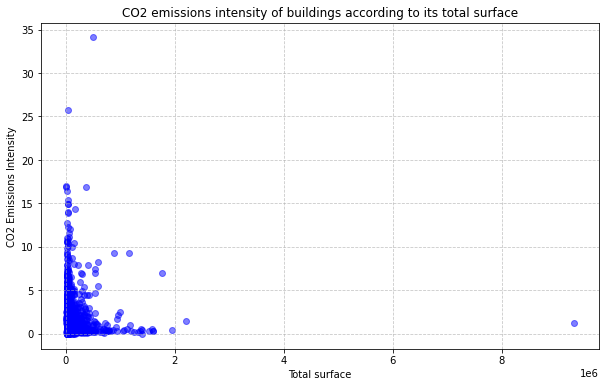

In [24]:
plt.figure(figsize=(10, 6))

plt.scatter(data_complete['PropertyGFATotal'], data_complete['GHGEmissionsIntensity'], alpha=0.5, color='b')
plt.ylabel('CO2 Emissions Intensity')
plt.xlabel('Total surface')
plt.title('CO2 emissions intensity of buildings according to its total surface')

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<a id='another_cell_g'></a>

- <strong>Correlation between the total surface of a building and its energy consumption (intensity)</strong>

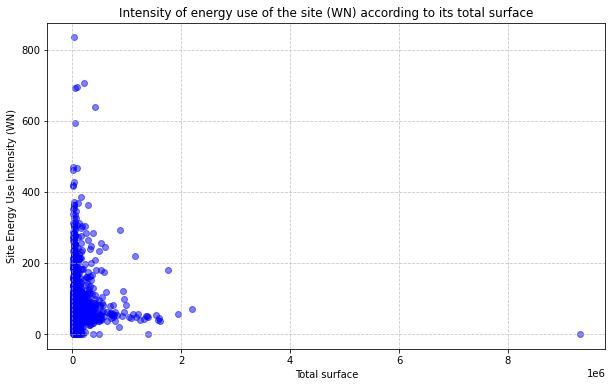

In [25]:
plt.figure(figsize=(10, 6))

plt.scatter(data_complete['PropertyGFATotal'], data_complete['SiteEUIWN(kBtu/sf)'], alpha=0.5, color='b')
plt.ylabel('Site Energy Use Intensity (WN)')
plt.xlabel('Total surface')
plt.title('Intensity of energy use of the site (WN) according to its total surface')

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<div class="alert-success">
☛ There is obviously a correlation between the total surface of a Seattle building and its actual energy consumption or CO2 emissions intensity : the smaller the area of a building in the city of Seattle, the greater the intensity of its energy consumption and its CO2 emissions.<br>
In other words, <strong>small non-residential buildings pollute more proportionally than larger ones.</strong>
</div>

<a id='another_cell_h'></a>

- <strong>Correlation between the year of construction of a building and its CO2 emissions (intensity)</strong>

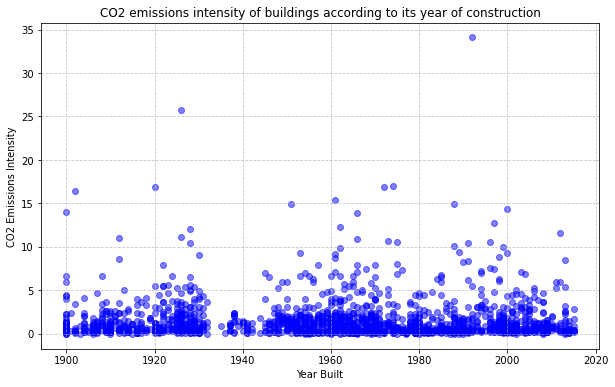

In [26]:
plt.figure(figsize=(10, 6))

plt.scatter(data_complete['YearBuilt'], data_complete['GHGEmissionsIntensity'], alpha=0.5, color='b')
plt.ylabel('CO2 Emissions Intensity')
plt.xlabel('Year Built')
plt.title('CO2 emissions intensity of buildings according to its year of construction')

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<a id='another_cell_i'></a>

- <strong>Correlation between the year of construction of a building and its energy consumption (intensity)</strong>

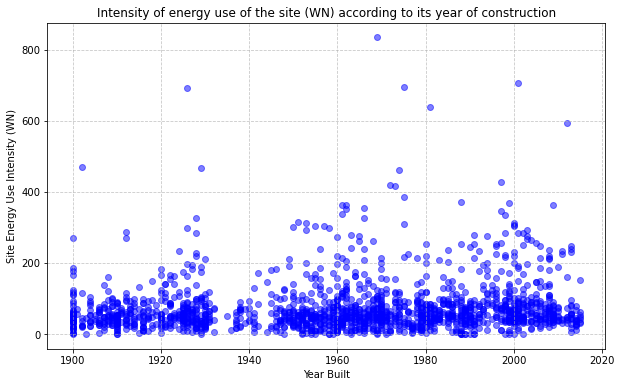

In [27]:
plt.figure(figsize=(10, 6))

plt.scatter(data_complete['YearBuilt'], data_complete['SiteEUIWN(kBtu/sf)'], alpha=0.5, color='b')
plt.ylabel('Site Energy Use Intensity (WN)')
plt.xlabel('Year Built')
plt.title('Intensity of energy use of the site (WN) according to its year of construction')

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<div class="alert-success">
☛ There is obviously no correlation between the year of construction of a building and its actual energy consumption or CO2 emissions
</div>

### C. <i>2016_Building_Energy_Benchmarking.xlsx</i> : data standardization

<a id='another_cell_j'></a>

- <strong>Quantitative data standardisation</strong>

In [28]:
# Standardize the data
columns_to_normalize = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'SiteEUIWN(kBtu/sf)',
                         'GHGEmissionsIntensity', 'ENERGYSTARScore']

scaler = StandardScaler()
data_complete[columns_to_normalize] = scaler.fit_transform(data_complete[columns_to_normalize])

# Check
pd.DataFrame(data_complete[columns_to_normalize]).describe().round(2)

,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,ENERGYSTARScore
count,1665.00,1665.00,1665.00,1665.00,1665.00,1665.00
mean,0.00,-0.00,-0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.40,-0.63,-0.36,-0.99,-0.70,-1.11
25%,-0.06,-0.48,-0.30,-0.52,-0.54,-1.11
50%,-0.06,-0.32,-0.23,-0.28,-0.31,0.08
75%,-0.06,-0.02,-0.05,0.14,0.12,0.98
max,37.47,14.45,30.93,10.13,13.90,1.47


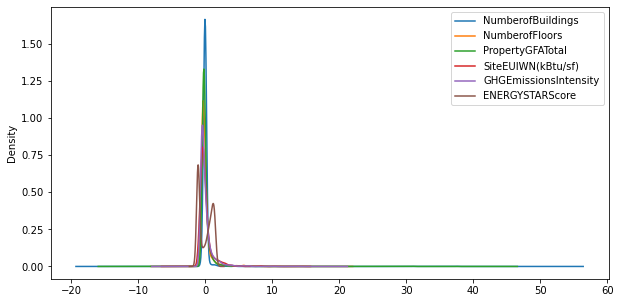

In [29]:
# Standardised data
pd.DataFrame(data_complete[columns_to_normalize]).plot(kind='density',sharex=True,
                                               figsize=(10,5),layout=(10,1))
plt.show()

<a id='another_cell_k'></a>

- <strong>Scaling the <i>YearBuild</i> variable</strong>

We scale this variable before feeding it to the ML models to have features on a similar scale.
This transformation will help the gradient descent converge more quickly towards the minima.

In [30]:
# Scaling the "YearBuild" variable
scaler = MinMaxScaler()
data_complete['YearBuilt'] = scaler.fit_transform(data_complete['YearBuilt'].values.reshape(-1, 1))

In [31]:
data_complete.head()

,OSEBuildingID,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity,ENERGYSTARScore,BuildingType_Campus,BuildingType_NonResidential,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,1,0.234783,-0.057573,1.199873,-0.102490,0.129743,0.522803,0.440595,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.834783,-0.057573,1.047591,-0.051631,0.311062,0.535641,0.466434,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.600000,-0.057573,5.616052,2.813796,0.308395,0.248924,0.001335,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,0.226087,-0.057573,0.895309,-0.193621,0.516379,1.310203,0.337240,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0.695652,-0.057573,2.113565,0.190410,0.588374,0.544199,0.828178,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
data_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 54 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   OSEBuildingID                                    1665 non-null   int64  
 1   YearBuilt                                        1665 non-null   float64
 2   NumberofBuildings                                1665 non-null   float64
 3   NumberofFloors                                   1665 non-null   float64
 4   PropertyGFATotal                                 1665 non-null   float64
 5   SiteEUIWN(kBtu/sf)                               1665 non-null   float64
 6   GHGEmissionsIntensity                            1665 non-null   float64
 7   ENERGYSTARScore                                  1665 non-null   float64
 8   BuildingType_Campus                              1665 non-null   float64
 9   BuildingType_NonResidential   

<a id='another_cell_l'></a>

### Conclusion (part 1)

<div class="alert-success">
There are 1665 entries and 54 columns in the final standardised dataframe :<br>
<i>→ data were filtered on non-residential buildings ;<br>
→ 11 variables were selected to respond to the project (3 categorical variables and 8 numerical variables) ;<br>
→ the qualitative data were encoded and the quantitative variables standardized to train our different prediction models (part 2 and 3) ;<br>
→ our short exploratory analysis informs us that there is no direct correlation between the year of construction of buildings and their energy consumption or CO2 emissions but there is one with the "total surface" variable: small non-residential buildings pollute more proportionally than larger ones.</i><br>
</div>

In [33]:
data_complete.to_csv("export_building_energy_bench_data.csv", sep=';')